# Combining Physics and Machine Learning using JAX 

![](2022-01-19-15-18-00.png) ![](2022-01-20-09-03-59.png)


Topics:
1. How to convert mathematical description of an ODE into Python code
2. How to write and use numerical solvers in Python
3. How to use to estimate a unknown term of an ODE using automatic differentiation
4. How to replace an ODE with a neural network in cases where dynamics are completely unknown

In [249]:
import numpy as np
import jax.numpy as jnp
%matplotlib widget
import matplotlib.pyplot as plt

## Dynamics of ideal pendulum

We want to predict how the angle of a pendulum, $u$ changes as a function of time subject to gravity.
The dynamical system can be characterized by two states: 
* $\theta$ : the angle
* $\omega$ : the angular velocity

Note that the states of a system do not have to be derivatives of each other, it just happens to be the case for many dynamical systems describing physical phenomena.

![](2022-01-19-15-19-07.png)

### Defining ODE in Python

In [250]:
def f(y):
    θ,ω = y 
    dθ = ω # change of angle w.r.t. time is per definition ω
    dω = -(g/m)*jnp.sin(θ)
    return dθ, dω

print(f((0.7,0.7)))

(0.7, DeviceArray(-0.64421767, dtype=float32, weak_type=True))


### Vector Fields and Phase portrait

A phase portrait is a way to depict how a point in state-space will evolve over time.
The arrows indicate the direction a point will follow over time.

![](2022-01-19-15-21-13.png)

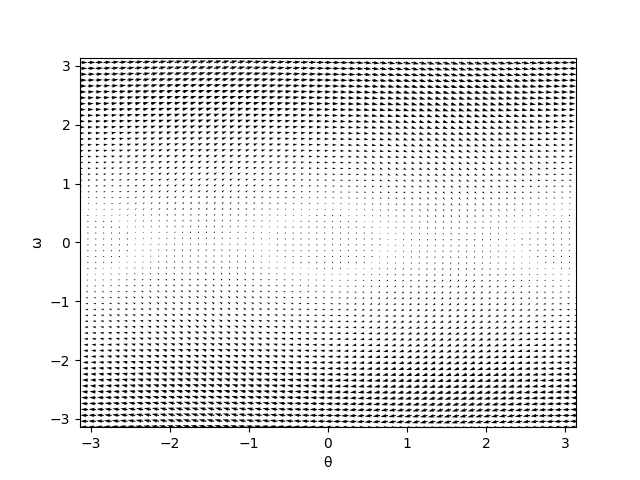

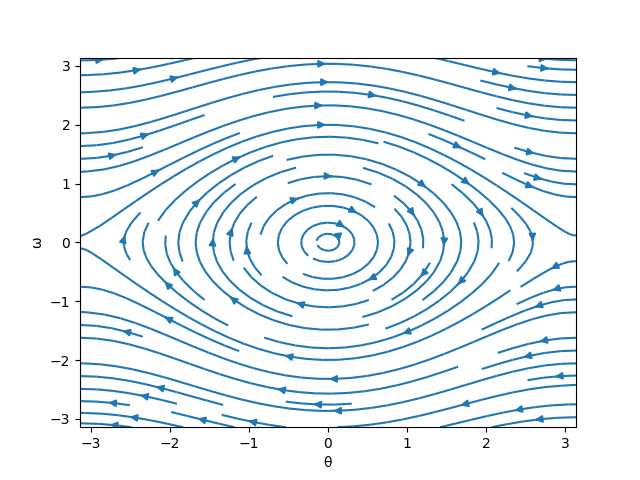

In [251]:
m = 1.0 # mass
g = 1.0 # gravity

θ_min = -np.pi
θ_max = np.pi
ω_min = -np.pi
ω_max = np.pi
θ_res = 0.1
ω_res = 0.1

def f(y):
    θ,ω = y 
    dθ = ω
    dω = -(g/m)*jnp.sin(θ)
    return dθ, dω

θ, ω = np.meshgrid(np.arange(θ_min,θ_max+θ_res,θ_res), np.arange(ω_min, ω_max+ω_res,ω_res))
dθ, dω = f((θ, ω))

fig, ax = plt.subplots()
plt.quiver(θ,ω, dθ, dω, scale_units="xy",angles="xy")
plt.xlabel("θ")
plt.ylabel("ω")
ax.set_xlim(θ_min,θ_max)
ax.set_ylim(ω_min,ω_max)

fig, ax = plt.subplots()
plt.streamplot(θ,ω, dθ, dω)
plt.xlabel("θ")
plt.ylabel("ω")
ax.set_xlim(θ_min,θ_max)
ax.set_ylim(ω_min,ω_max);


### Obtaining a trajectory using a numerical solver

The dynamics of the system describe how a given state will change over the next inifinitely small step in time.
Using the dynamics we want to obtain a trajectory of system states as they evolve over time from some initial state $y_0$.

In the end we will be able to plot each state as function of time:

![](2022-01-19-15-22-51.png)

#### Implementing Forward Euler

![](2022-01-20-09-16-07.png)

$y_{k+1} = y_k + h*f(y)$

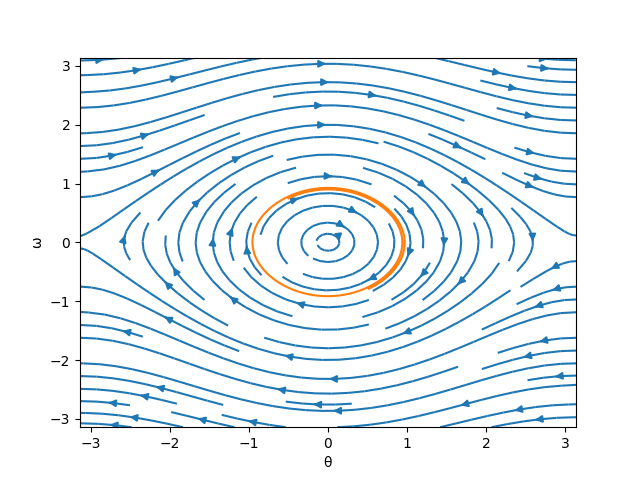

In [252]:
n_steps = 1000
dt = 0.01
y0 = (-0.5, 0.75)

def f(y):
    θ,ω = y 
    dθ = ω
    dω = -(g/m)*jnp.sin(θ)
    return np.asarray((dθ, dω))

def simulate(y0, n_steps, dt):
   
    y = y0
    ys = [y0]
    for _ in range(n_steps):
        dy = f(y)
        y = y + dt*dy
        ys.append(y)
    
    return np.stack(ys,axis=1)

θ_sol, ω_sol = simulate(y0,n_steps,dt)

fig, ax = plt.subplots()
plt.streamplot(θ,ω, dθ, dω)
plt.plot(θ_sol, ω_sol)
plt.xlabel("θ")
plt.ylabel("ω")
ax.set_xlim(θ_min,θ_max)
ax.set_ylim(ω_min,ω_max);

#### Using third-party solver

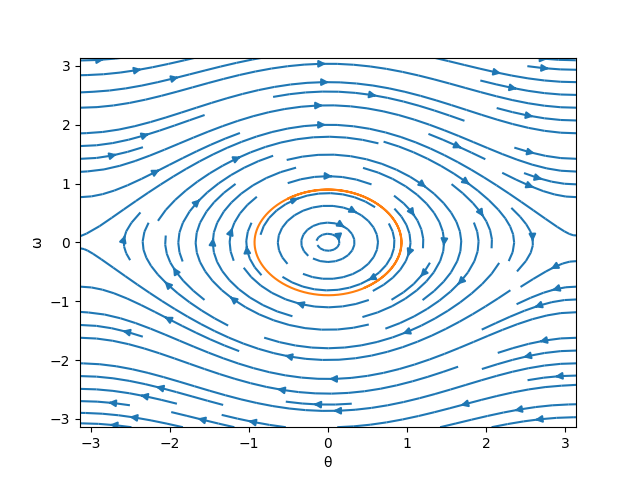

In [253]:
from scipy.integrate import solve_ivp

t_start = 0.0
t_end = 10.0
t_eval = np.arange(t_start,t_end+dt, dt)
θ_sol, ω_sol = solve_ivp(lambda t, y : f(y), (t_start,t_end), y0, "RK45", t_eval).y

fig, ax = plt.subplots()
plt.streamplot(θ,ω, dθ, dω)
plt.plot(θ_sol, ω_sol)
plt.xlabel("θ")
plt.ylabel("ω")
ax.set_xlim(θ_min,θ_max)
ax.set_ylim(ω_min,ω_max);

## Learning dynamics from data
![](2022-01-19-15-24-47.png)

In [254]:
from jax.experimental.stax import serial, Dense, Softplus
from jax import vmap, value_and_grad, jit, random
from jax.lax import scan
import jax.numpy as jnp
from tqdm import tqdm

key = random.PRNGKey(0) # every random operation in jax is seeded

## Partially known dynamics and Parameter Estimation
Suppose we know the shape of the derivative function, but only have rough estimates of the coefficients?
For instance we may not know what the exact weight of the pendulum arm is.

(-3.141592653589793, 3.141592653589793)

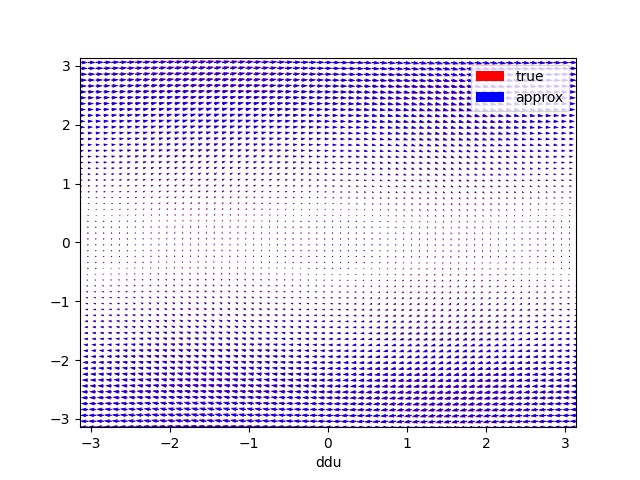

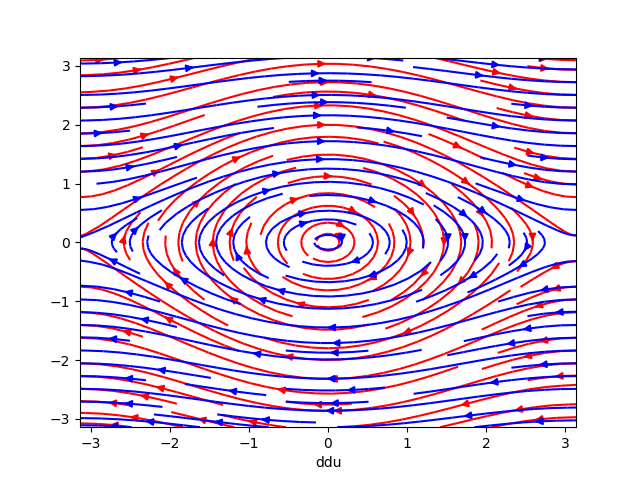

In [255]:
m_true = 1.0
m_approx = 2.0
g = 1.0

# dynamics are explicitly dependent on our estimate of m
def f(y, m):
    θ,ω = y 
    dθ = ω
    dω = -(g/m)*jnp.sin(θ)
    return np.asarray((dθ, dω))

θ, ω = np.meshgrid(np.arange(θ_min,θ_max+θ_res,θ_res), np.arange(ω_min, ω_max+ω_res,ω_res))
dθ_true, ddu_true = f((θ, ω), m_true)
dθ_approx, dω_approx = f((θ, ω), m_approx)

fig, ax = plt.subplots()
ax.quiver(θ, ω, dθ_true, ddu_true, scale_units="xy",angles="xy", label="true", color="red")
ax.quiver(θ, ω, dθ_approx, dω_approx, scale_units="xy",angles="xy", label="approx", color="blue")
ax.legend()
ax.set_xlabel("du")
ax.set_xlabel("ddu")
ax.set_xlim(θ_min, θ_max)
ax.set_ylim(ω_min,ω_max)

fig, ax = plt.subplots()
ax.streamplot(θ, ω, dθ_true, ddu_true, color="red")
ax.streamplot(θ, ω, dθ_approx, dω_approx, color="blue")
ax.set_xlabel("du")
ax.set_xlabel("ddu")
ax.set_xlim(θ_min, θ_max)
ax.set_ylim(ω_min,ω_max)

Is it possible to tune optimize the choice of $\hat{m}$ such that the dynamics of the true system are approximated well?

Two scenarios are:
1. We know ground truth derivatives, $d\theta, d\omega$
2. We know ground solutions trajectories $\theta(t), \omega(t)$

In both cases we:
1. Define a loss function that measures the error in predictions for the models parameters, $\theta$
2. Obtain sensitivity of loss on models parameters $\frac{dL}{d\theta}(\theta)$
3. Update parameters to minimize loss

We use [JAX](https://jax.readthedocs.io/en/latest/) to implement the optimization loop.

### Minimize Error based on true derivatives

training: 100%|██████████| 60/60 [00:00<00:00, 1540.01it/s]


(-3.141592653589793, 3.141592653589793)

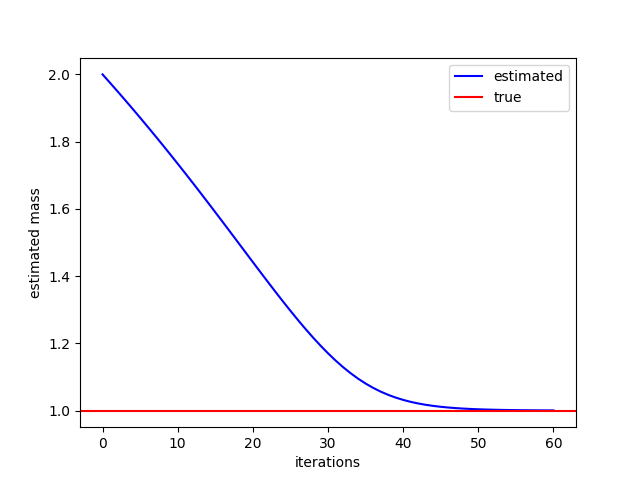

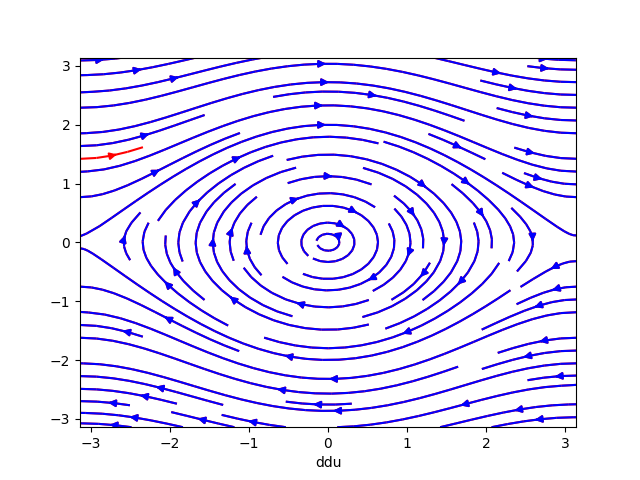

In [256]:
m_approx = 2.0
learning_rate = 1e-4

def f(y, m):
    θ,ω = y 
    dθ = ω
    dω = -(g/m)*jnp.sin(θ)
    return jnp.asarray((dθ, dω))

y = np.meshgrid(np.arange(θ_min,θ_max+θ_res,θ_res), np.arange(ω_min, ω_max+ω_res,ω_res))
dy_true = f(y, m_true)

def loss(m):
    dy_approx = f(y,m)
    return jnp.sum((dy_approx - dy_true)**2) / dy_approx.shape[0]

@jit
def update(m):
    value, grad = value_and_grad(loss, argnums=0)(m)
    m = m - learning_rate * grad
    return m


ms = [m_approx]
for i in tqdm(range(60),desc="training"):
    
    m_approx = update(m_approx)
    ms.append(m_approx)

fig, ax = plt.subplots()
ax.plot(ms,label="estimated",c="blue")
ax.set_xlabel("iterations")
ax.set_ylabel("estimated mass")
ax.axhline(m_true,label="true",c="red")
ax.legend()

dy_approx = f(y,m_approx)

fig, ax = plt.subplots()
ax.streamplot(θ, ω, *dy_true, color="red")
ax.streamplot(θ, ω, *dy_approx, color="blue")
ax.set_xlabel("du")
ax.set_xlabel("ddu")
ax.set_xlim(θ_min, θ_max)
ax.set_ylim(ω_min,ω_max)

### Minimize error based on solution
Alternatively, if we only have the solutions for dynamical system, we can use those to infer the parameters of the dynamics that result in the solution we have observed.
The process for tuning based on this is:
1. take an initial guess on m
2. simulate the system for initial conditions corresponding to those of the ground truth
3. calculate the difference between the solution produced by the approximate m and the ground truth
4. update m such that the difference is minimized
5. repeat 2-4

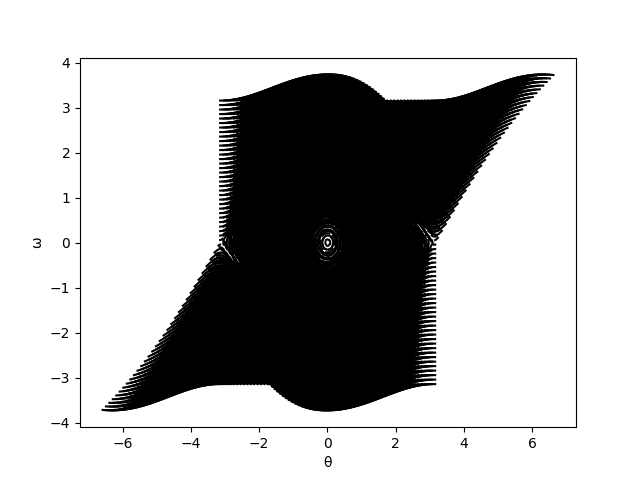

In [257]:
# simulate and stack results for ease of plotting

y0 = np.meshgrid(np.arange(θ_min,θ_max+θ_res,θ_res), np.arange(ω_min, ω_max+ω_res,ω_res))
y0 = np.stack(y)
n_steps = 100

def simulate(y0, n_steps, dt, m):
   
    y = y0
    ys = [y0]
    for _ in range(n_steps):
        dy = f(y, m)
        y = y + dt*dy
        ys.append(y)
    
    return np.stack(ys,axis=1)

y_true = simulate(y0,n_steps,dt,m_true)
θ_sol, ω_sol = y_true
θ_sol = θ_sol.reshape(θ_sol.shape[0],-1)
ω_sol = ω_sol.reshape(ω_sol.shape[0],-1)


fig, ax = plt.subplots()
ax.set_xlabel("θ")
ax.set_ylabel("ω")
ax.plot(θ_sol, ω_sol, color="black");

training: 100%|██████████| 20/20 [00:00<00:00, 64.42it/s]


(-3.141592653589793, 3.141592653589793)

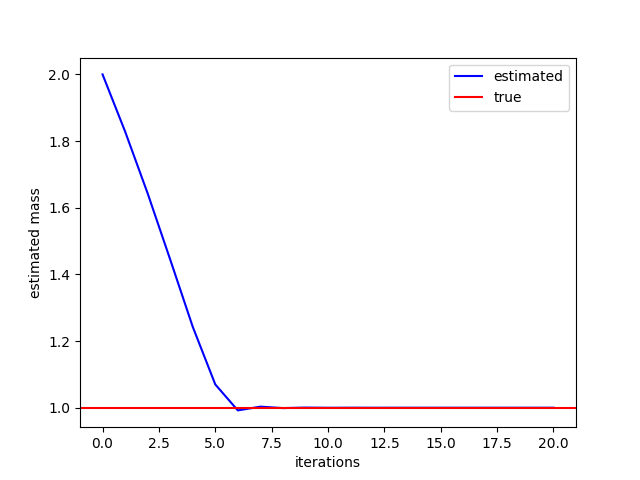

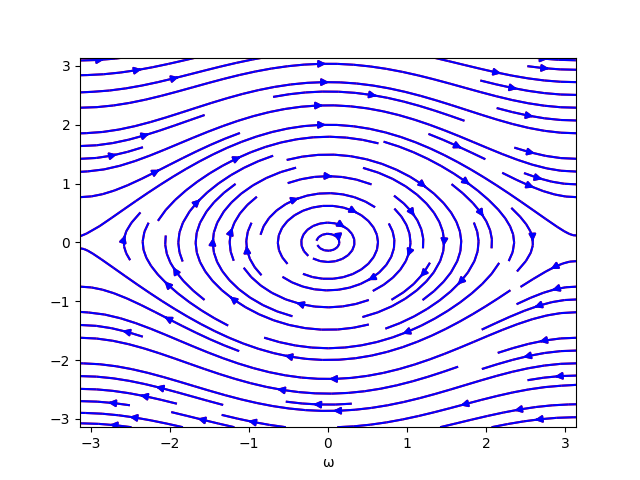

In [258]:
m_approx = 2.0
learning_rate = 0.001
t_start = 0.0
t_end = 1.0
dt = 0.01
t_eval = jnp.arange(t_start,t_end+dt,dt)

y0 = np.meshgrid(np.arange(-1.0,1.0+θ_res,θ_res), np.arange(1.0, 1.0+ω_res,ω_res))
y0 = np.stack(y)

def f(y, m):
    θ,ω = y 
    dθ = ω
    dω = -(g/m)*jnp.sin(θ)
    return jnp.asarray((dθ, dω))

# simulate optimized for JAX just-in-time compilation
def simulate(y0, t_eval, m):
    
    def h(y, slice):
        
        dy = f(y,m)
        y = y + dt*dy
        return y,y

    _, y = scan(h,y0, None, t_eval.shape[0])

    return y

y_true = simulate(y0,t_eval,m_true)

@jit
def update(m):
    def loss(m):        
        y = simulate(y0,t_eval,m)
        return jnp.sum((y_true - y)**2) / y.shape[0]

    value, grad = value_and_grad(loss, argnums=0)(m)
    m = m - learning_rate * grad
    return m

ms = [m_approx]
for i in tqdm(range(20),desc="training"):
    
    m_approx = update(m_approx)
    ms.append(m_approx)

fig, ax = plt.subplots()
ax.plot(ms,label="estimated",c="blue")
ax.set_xlabel("iterations")
ax.set_ylabel("estimated mass")
ax.axhline(m_true,label="true",c="red")
ax.legend()


y0 = np.meshgrid(np.arange(θ_min,θ_max+θ_res,θ_res), np.arange(ω_min, ω_max+ω_res,ω_res))
dy_true = f(y0,m_true)
dy_approx = f(y0,m_approx)

fig, ax = plt.subplots()
ax.streamplot(θ, ω, *dy_true, color="red")
ax.streamplot(θ, ω, *dy_approx, color="blue")
ax.set_xlabel("θ")
ax.set_xlabel("ω")
ax.set_xlim(θ_min, θ_max)
ax.set_ylim(ω_min,ω_max)


## Completely unknown dynamics

In cases where the dynamics are totally unknown we can replace the explicitly defined derivative function with a *feed-forward neural network*.

### Constructing the network

In [259]:
init_net, net = serial(Dense(32),Softplus, Dense(2))

_, params = init_net(key,(2,))

net(params, jnp.ones((2,)))

DeviceArray([-0.31260395, -1.5107025 ], dtype=float32)

### Forward pass

In [260]:
def f(y, m):
    θ,ω = y 
    dθ = ω
    dω = -(g/m)*jnp.sin(θ)
    return jnp.asarray((dθ, dω))

def simulate(m, y0, t_eval):
    
    def h(y, slice):
        
        dy = f(y,m)
        y = y + dt*dy
        return y,y

    _, y = scan(h,y0, None, t_eval.shape[0])

    return y

def simulate_net(params, y0, t_eval):
    
    def h(y, slice):
        
        dy = net(params,y) # only difference
        y = y + dt*dy
        return y,y

    _, y = scan(h,y0, None, t_eval.shape[0])

    return y

# map method such that it can take y0's of the shape (n_states, nx, ny)
simulate_net = vmap(simulate_net, (None, 1, None), 2)
simulate_net = vmap(simulate_net, (None, 2, None), 3)
simulate = vmap(simulate, (None, 1, None), 2)
simulate = vmap(simulate, (None, 2, None), 3)

### Optimization loop
the parameters of a NN are represented as a tree structure unlike before when the only parameters was scalar.

To faclitate the update of the coefificents we use an optimizer from jax.experimental.optimizers

training: 100%|██████████| 10000/10000 [03:33<00:00, 46.93it/s]


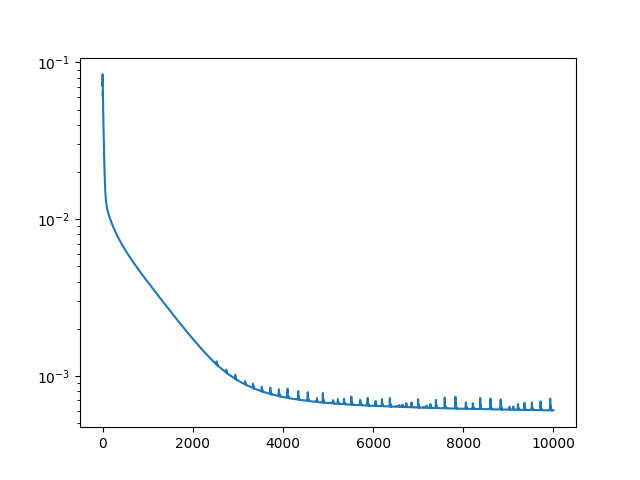

In [268]:
from jax.experimental.optimizers import adam

init_fun, update_fun, get_params = adam(learning_rate)
opt_state = init_fun(params)
t_eval = jnp.arange(0.0,0.1, 0.01)
losses = []

y0 = np.meshgrid(np.arange(θ_min,θ_max+θ_res,θ_res), np.arange(ω_min, ω_max+ω_res,ω_res))
y0 = np.stack(y0)

y_true = simulate(m_true, y0,t_eval)

@jit
def update(opt_state):
    
    def loss(params):        
        y = simulate_net(params,y0,t_eval)
        return jnp.sum((y_true - y)**2) / y.shape[0]

    value, grads = value_and_grad(loss, argnums=0)(get_params(opt_state))
    opt_state = update_fun(0,grads,opt_state)    
    return value, opt_state

for i in tqdm(range(10000),desc="training"):
    value, opt_state = update(opt_state)
    losses.append(value)

params = get_params(opt_state)

fig,ax = plt.subplots()
ax.plot(losses)
ax.set_yscale("log")


### Validation

(-3.141592653589793, 3.141592653589793)

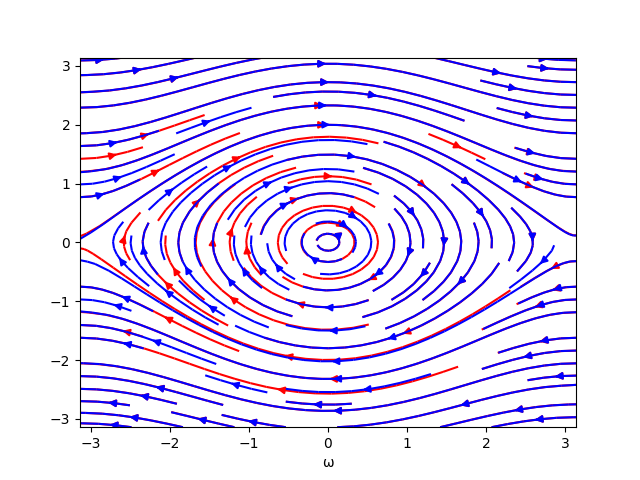

In [269]:
y0 = np.meshgrid(np.arange(θ_min,θ_max+θ_res,θ_res), np.arange(ω_min, ω_max+ω_res,ω_res))
y0 = np.stack(y0)

dy_true = f(y0,m_true)

# network function expects (2,) we vectorize to (2,nx,ny)
forward_grid = vmap(net, (None, 1), 1)
forward_grid = vmap(forward_grid, (None, 2), 2)
dy_approx = forward_grid(params, y0)


fig, ax = plt.subplots()
ax.streamplot(θ, ω, *dy_true, color="red")
ax.streamplot(θ, ω, *dy_approx, color="blue")
ax.set_xlabel("θ")
ax.set_xlabel("ω")
ax.set_xlim(θ_min, θ_max)
ax.set_ylim(ω_min,ω_max)
